# Predictive Maintenance for Aircraft Engines

## 1. Introduction

This project focuses on building a predictive maintenance pipeline for aircraft engines. In the aerospace and defense sectors, equipment failure isn't just a financial risk, it's a mission-critical safety concern. By leveraging the NASA CMAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset, this notebook demonstrates how to predict the Remaining Useful Life (RUL) of turbofan engines using sensor telemetry data.

## 2. Objective

The primary goal is to develop a machine learning model that can accurately estimate the number of remaining flight cycles before an engine requires maintenance.

* Input: 21 sensor channels (temperature, fan speeds, preassure, etc...).
* Output: A continuous value representing the RUL (Remaining Useful Life).


## 3. Data Description

The dataset consists of multiple "run-to-failure" simulations. Each engine starts with varying degrees of initial wear but is considered healthy at the beginning of the record. Over time, the engine develops faults that eventually lead to functional failure.

Dataset was downloaded from: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

* Train set: Complete histories of engines from start to failure

* Test set: Sensor data that terminates at some point prior to failure.

* Ground truth: The actual RUL values for the test set engines to validate model performance.

## 4.  Approach

1. Data Engineering: Ingesting raw .txt data and structuring it into a time-series format

2. Feature scaling: Normalizing sensor data to account for different units of measurement

3. Exploratory Data Analysis (EDA): Identifying which sensors is most correlated to failure.  

4. Model Development: Implementing regression-based algorithms to map sensor patterns to RUL.

In [201]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define column names based on NASA documentation
index_names = ['unit_id', 'time_cycles']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

## 5. Data Loading

Load the dataset into a pandas DataFrame. This section should include code to import the data from its source (e.g., CSV, database, API).

In [202]:
# Load the FD001 training set
train = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None, names=col_names)

# Let's preview our dataset
print(train.shape)
train.head()

(20631, 26)


,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 6. Initial Data Preprocessing

In the training set, we know exactly when each engine failed (the last cycle recorded for that ID). To train a model, we need to calculate how many cycles were left at every single point in time.

In [203]:
# Group by engine ID and find the maximum cycle for each
max_cycle = train.groupby('unit_id')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_id', 'max_cycles']

# Merge that info back into the main dataframe
train = train.merge(max_cycle, on='unit_id', how='left')

# Calculate RUL: (Final Cycle - Current Cycle)
train['RUL'] = train['max_cycles'] - train['time_cycles']

# Drop the helper column
train.drop('max_cycles', axis=1, inplace=True)

## 7. Exploratory Data Analysis (EDA)

Let's analyze the data to discover patterns and anomalies.

In [204]:
train['time_cycles'].describe()

,time_cycles
count,20631.000000
mean,108.807862
std,68.880990
min,1.000000
25%,52.000000
50%,104.000000
75%,156.000000
max,362.000000


In [205]:
train.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [206]:
train.tail()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0


In [207]:
# checking for null values
train.isna().sum()

,0
unit_id,0
time_cycles,0
op_setting_1,0
op_setting_2,0
op_setting_3,0
sensor_1,0
sensor_2,0
sensor_3,0
sensor_4,0
sensor_5,0


In [208]:
# Let's check the average lifespan of our engines
train.groupby('unit_id')['time_cycles'].max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


Looks like all of our engines make it past the 128 use instance. We can improve the accuracy of our machine learning model if we add a upper boundary to the RUL reducing noise allowing our machine learning model to predict RUL better.

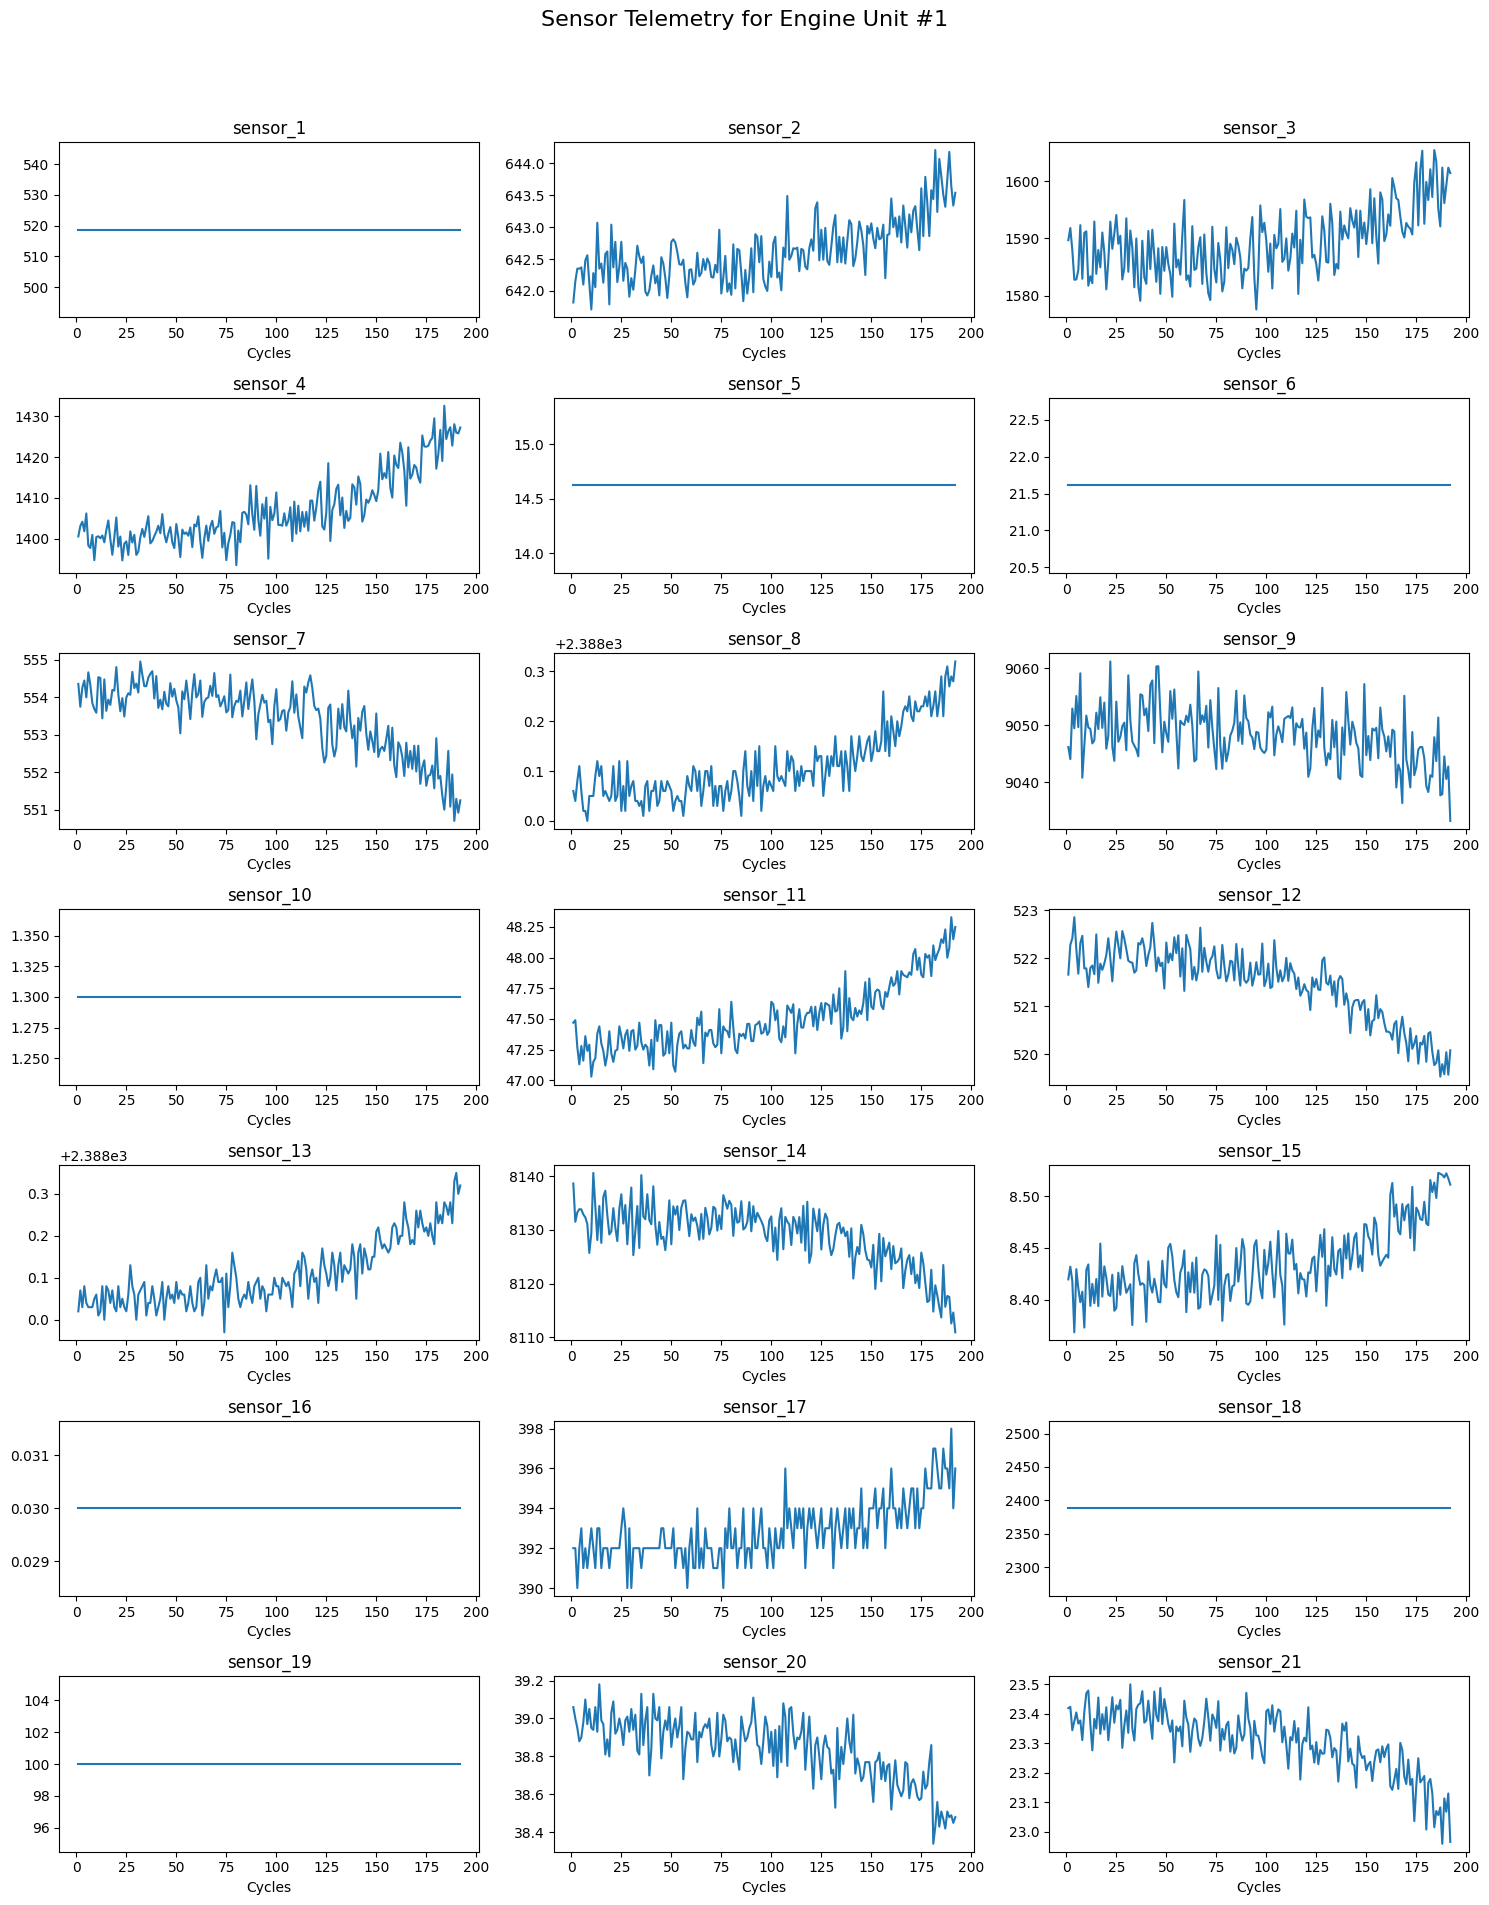

In [209]:
# Let's start looking at the first engine
unit_id = 1
engine_data = train[train['unit_id'] == unit_id]

# List all sensor columns
sensor_cols = []
for i in range (1,22):
  sensor_cols.append(f'sensor_{i}')

# Plot the sensor data
# Create a grid of plots (7 rows, 3 columns)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
fig.suptitle(f'Sensor Telemetry for Engine Unit #{unit_id}', fontsize=16)

for i, sensor in enumerate(sensor_cols):
    ax = axes[i//3, i%3]
    ax.plot(engine_data['time_cycles'], engine_data[sensor])
    ax.set_title(sensor)
    ax.set_xlabel('Cycles')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

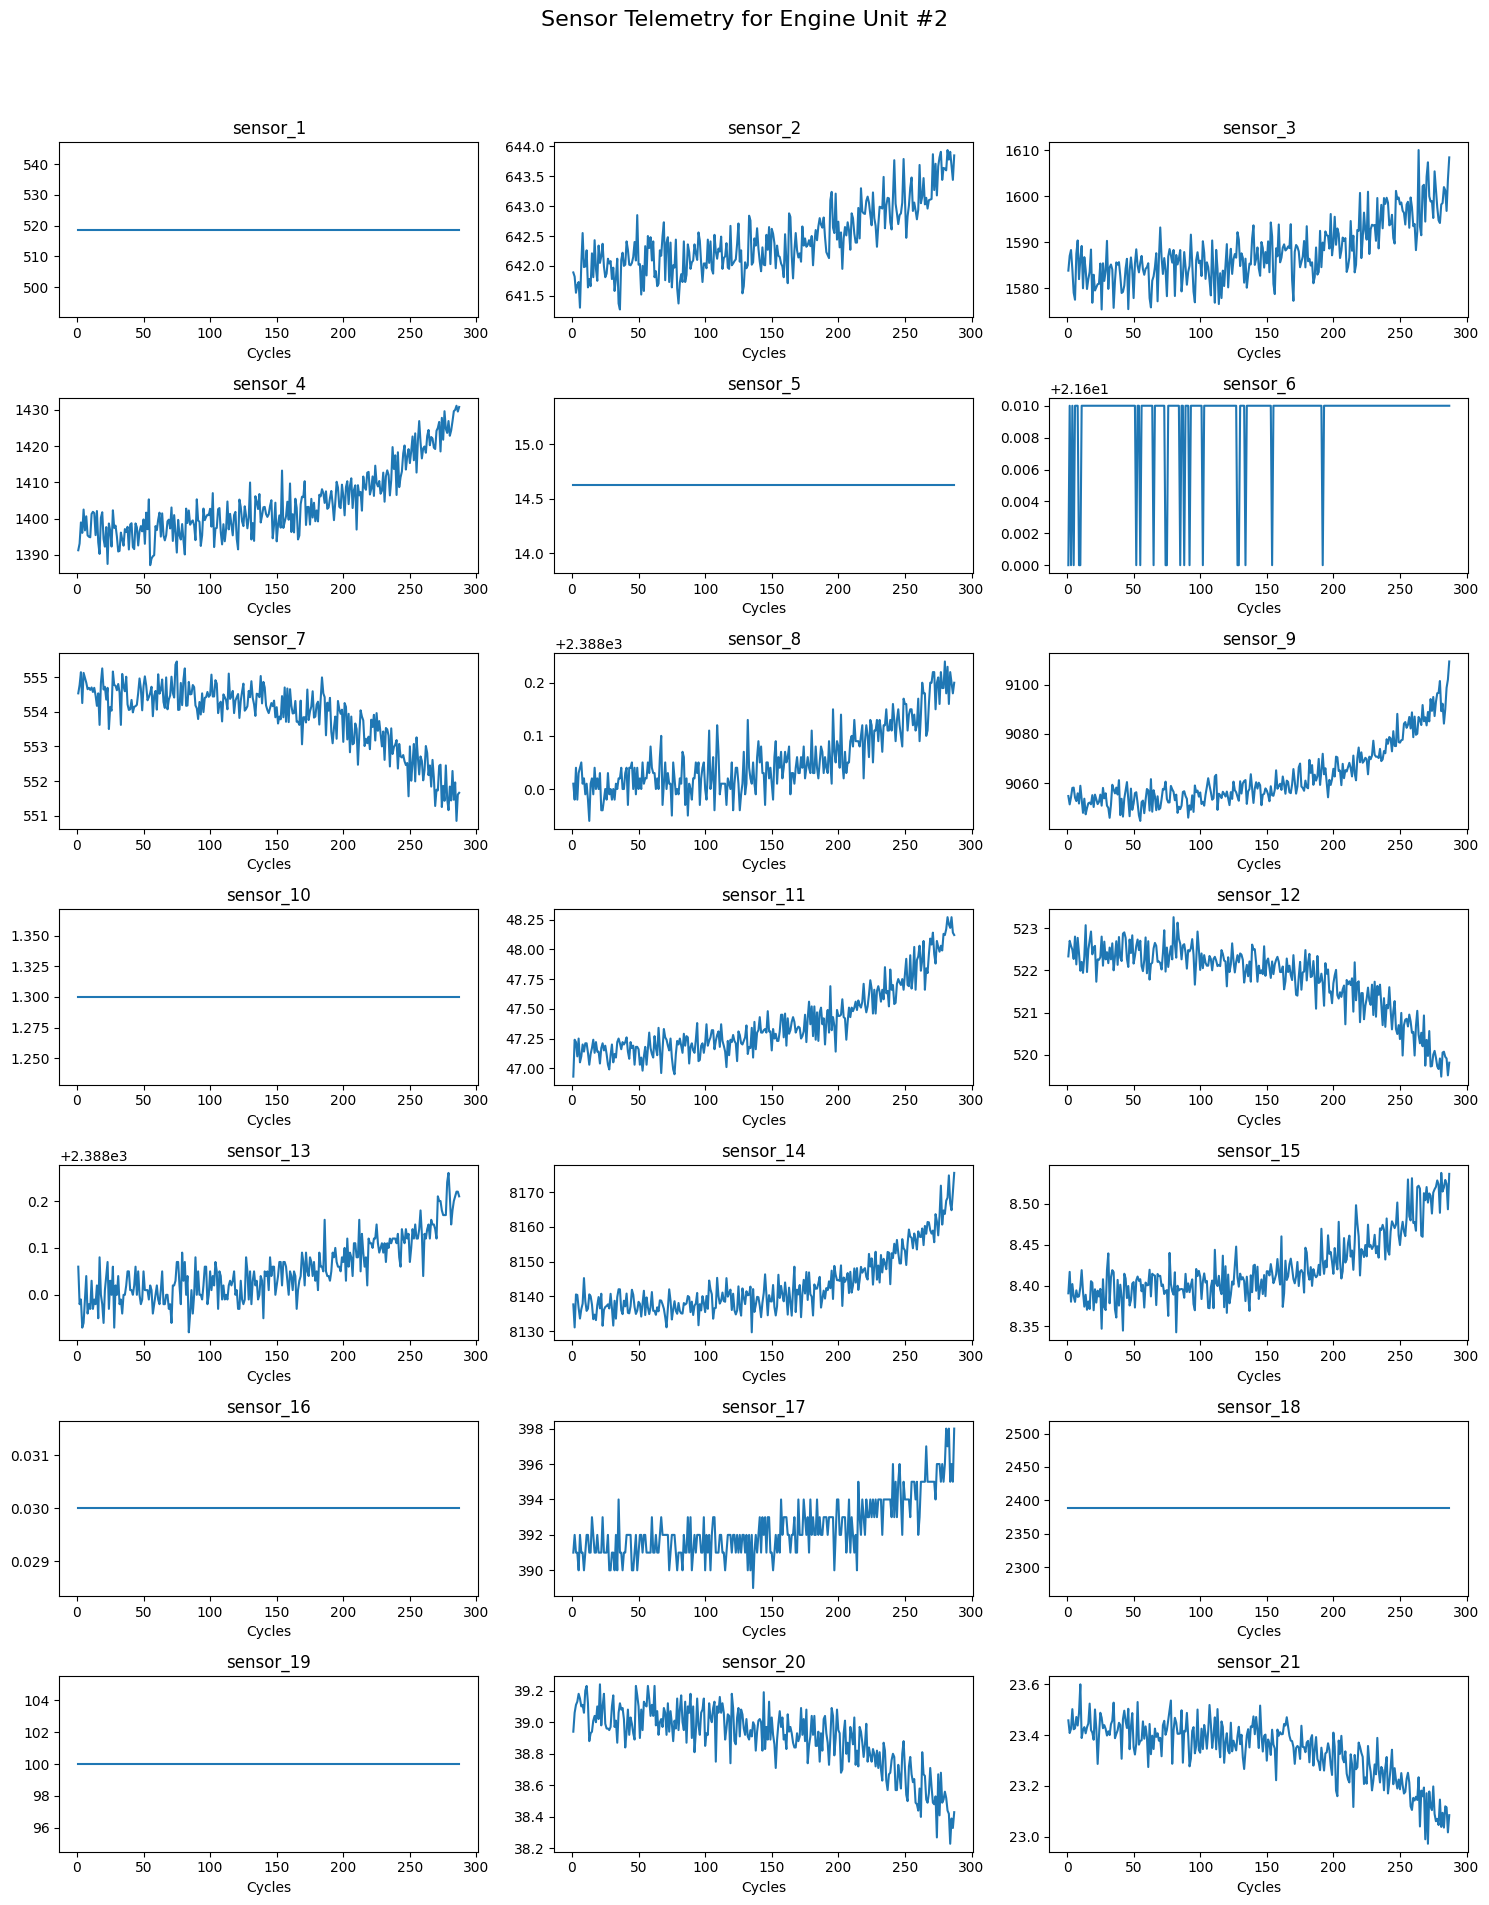

In [210]:
# Let's check the 2nd engine
unit_id = 2
engine_data = train[train['unit_id'] == unit_id]

# List all sensor columns
sensor_cols = []
for i in range (1,22):
  sensor_cols.append(f'sensor_{i}')

# Plot the sensor data
# Create a grid of plots (7 rows, 3 columns)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
fig.suptitle(f'Sensor Telemetry for Engine Unit #{unit_id}', fontsize=16)

for i, sensor in enumerate(sensor_cols):
    ax = axes[i//3, i%3]
    ax.plot(engine_data['time_cycles'], engine_data[sensor])
    ax.set_title(sensor)
    ax.set_xlabel('Cycles')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

It seems like there are some sensors that are "dead" and do not offer anything to our machine learning model. Let's take a look at all of the sensors across the whole dataset.

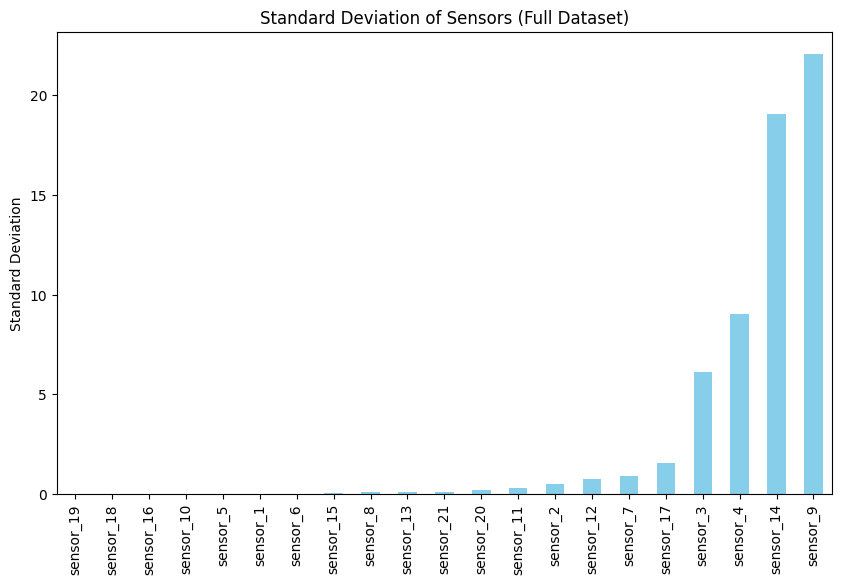

In [211]:
# Calculate standard deviation for each sensor across the whole dataset
sensor_std = train[sensor_cols].std().sort_values()

plt.figure(figsize=(10, 6))
sensor_std.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Sensors (Full Dataset)')
plt.ylabel('Standard Deviation');

Next let's take a look at the Operational Settings.

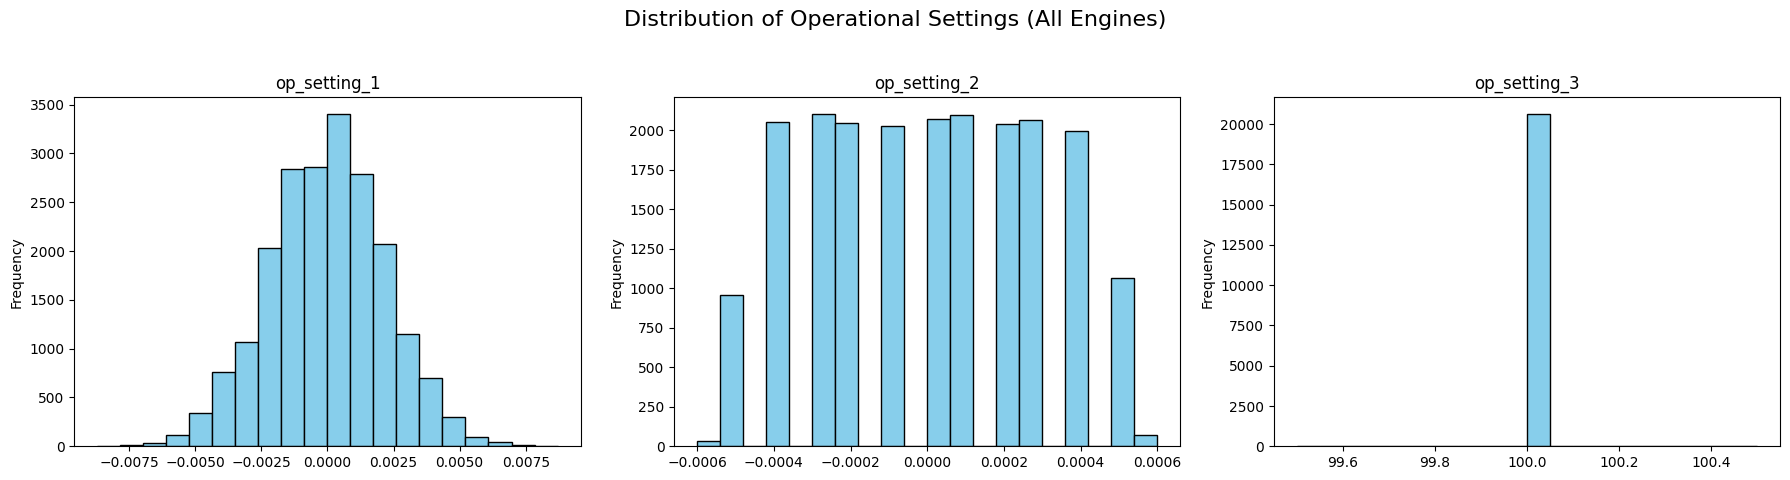

In [212]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Operational Settings (All Engines)', fontsize=16)

for i, setting in enumerate(setting_names):
    axes[i].hist(train[setting], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(setting)
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

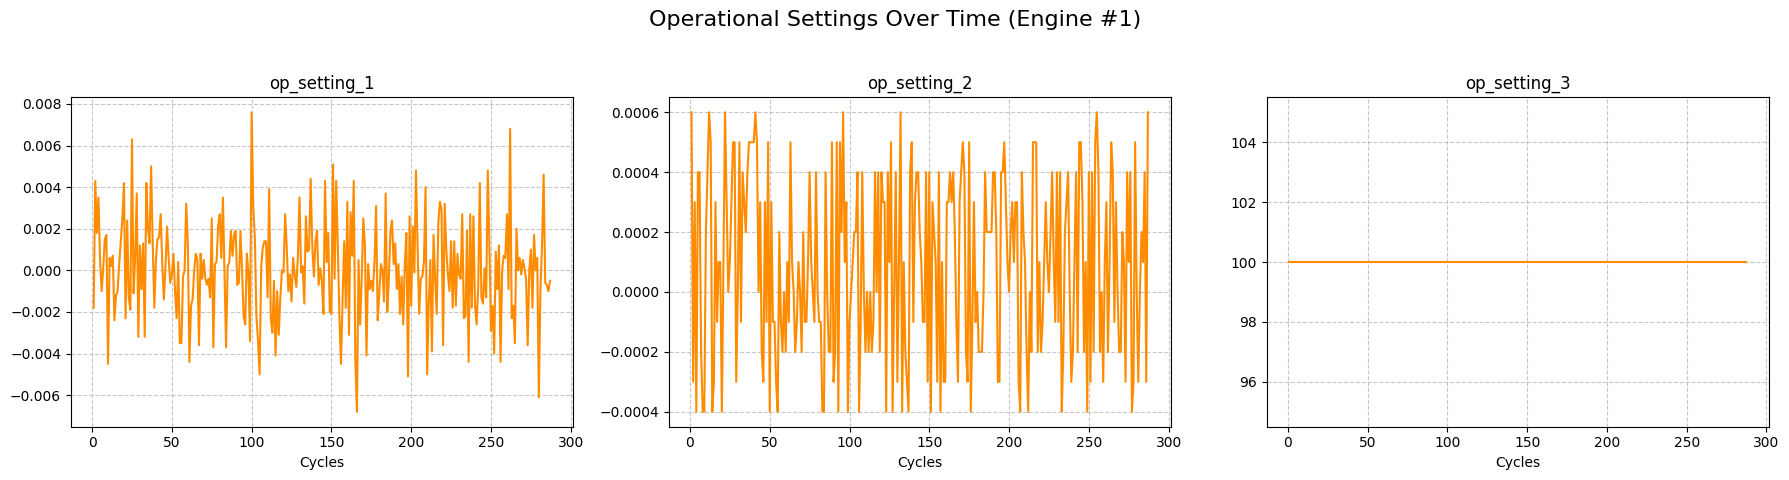

In [213]:
# Let's take a look at the op_setting charts
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Operational Settings Over Time (Engine #1)', fontsize=16)

for i, setting in enumerate(setting_names):
    axes[i].plot(engine_data['time_cycles'], engine_data[setting], color='darkorange')
    axes[i].set_title(setting)
    axes[i].set_xlabel('Cycles')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

The operational settings seem like they just indicate noise. It does not look like they will provide meaningful insights for our machine learning model. We will for sure drop op_setting_3 in our machine learning model. Before we drop the other 2 settings lets look at the heatmap first to help us make that decision.

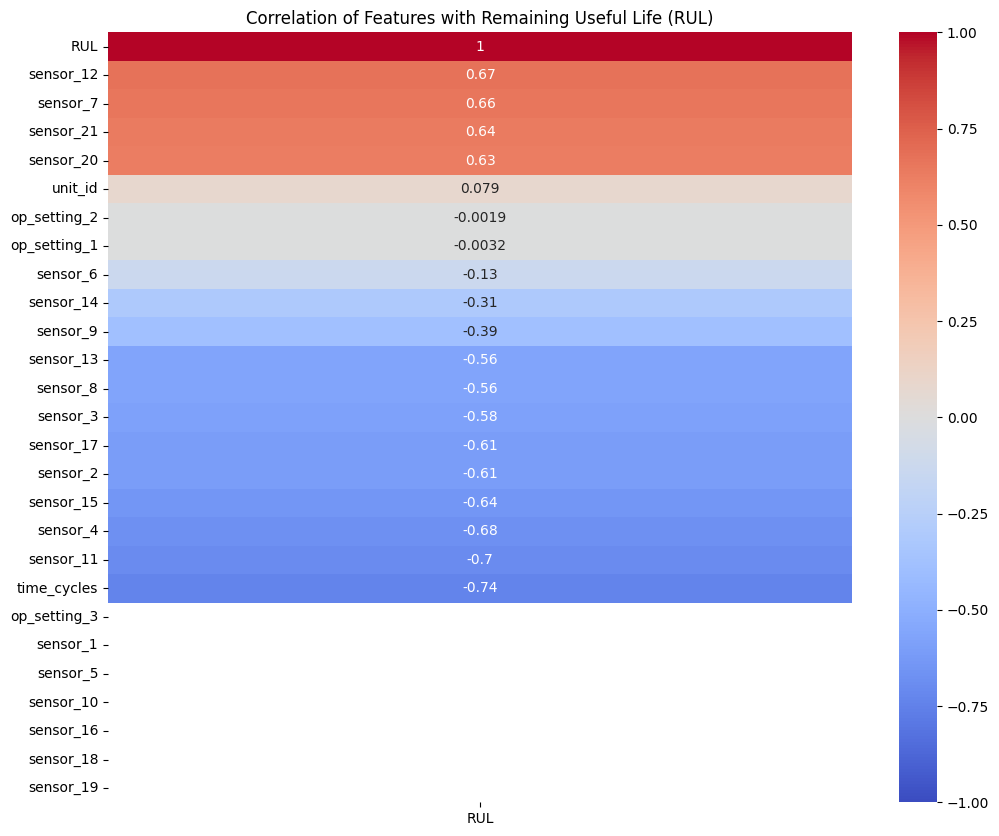

In [214]:
corr_matrix = train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['RUL']].sort_values(by='RUL', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Remaining Useful Life (RUL)');

This heatmap confirms most of our speculations. According to this correlation matrix heatmap, fields that do not influence RUL are:

* op_setting_1
* op_setting_2
* op_setting_3
* sensor_1
* sensor_5
* sensor_10
* sensor_16
* sensor_18
* sensor_19

sensor_6 will also be dropped because the r value between it and our RUL is negligable (less than |.2|).

> These fields will be dropped later before training our machine learning model.

## 8. Feature Selection

Let's start working on preparing our dataset for our machine learning model!

In [215]:
# List the columns, noise or constant
cols_to_drop = [
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10',
    'sensor_16', 'sensor_18', 'sensor_19'
]

# Drop them from your main training dataframe
train_preprocessed = train.drop(columns=cols_to_drop)

# Verify the new shape
print(f"Original columns: {len(train.columns)}")
print(f"Refined columns: {len(train_preprocessed.columns)}")
print(f"Remaining columns: {train_preprocessed.columns.tolist()}")

Original columns: 27
Refined columns: 17
Remaining columns: ['unit_id', 'time_cycles', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'RUL']


I removed variables with zero or near-zero variance. This ensures the model converges faster and focuses on the sensors that demonstrate clear degradation trends over the engine life-cycle.

In [216]:
# Clipping RUL before 115
train_preprocessed['RUL'] = train_preprocessed['RUL'].clip(upper=115)
train_preprocessed.head()

,unit_id,time_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,115
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,115
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,115
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,115
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,115


## 9. Feature Engineering

Let's create a Rolling Mean and Rolling Standard Deviation to assist with our machine learning model accuracy, before we do that we also have to remember to load in our test and official RUL data that NASA gives us.

In [217]:
# Load the test set
test = pd.read_csv('test_FD001.txt', sep=r'\s+', header=None, names=col_names)

# Load the truth RUL values
y_true = pd.read_csv('RUL_FD001.txt', sep=r'\s+', header=None, names=['RUL'])

test.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [218]:
# Function for our Rolling Mean and Standard Deviation
def add_features(df):
    # We are using these sensors because according to our heatmap these sensors have the biggest correlation with RUL
    relevant_sensors = ['sensor_11', 'sensor_4', 'sensor_12', 'sensor_15', 'sensor_7']

    # Calculate rolling mean and std for each engine
    for s in relevant_sensors:
        df[f'{s}_mean'] = df.groupby('unit_id')[s].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
        df[f'{s}_std'] = df.groupby('unit_id')[s].transform(lambda x: x.rolling(window=10, min_periods=1).std()).fillna(0)

    return df

# Apply to Training
train_preprocessed = add_features(train_preprocessed)

# Apply to Testing
test_refined = add_features(test)

In [219]:
# Let's verify that our new columns have been added
train_preprocessed.head()

,unit_id,time_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_11_mean,sensor_11_std,sensor_4_mean,sensor_4_std,sensor_12_mean,sensor_12_std,sensor_15_mean,sensor_15_std,sensor_7_mean,sensor_7_std
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,47.470,0.000000,1400.600000,0.000000,521.660,0.000000,8.419500,0.000000,554.360000,0.000000
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,47.480,0.014142,1401.870000,1.796051,521.970,0.438406,8.425650,0.008697,554.055000,0.431335
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,47.410,0.121655,1402.646667,1.850009,522.120,0.404475,8.423033,0.007640,554.123333,0.327159
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,47.340,0.171659,1402.452500,1.559645,522.305,0.495950,8.409325,0.028117,554.205000,0.313103
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,47.328,0.151063,1403.206000,2.159440,522.282,0.432574,8.413340,0.025953,554.164000,0.286234


In [220]:
test_refined.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_11_mean,sensor_11_std,sensor_4_mean,sensor_4_std,sensor_12_mean,sensor_12_std,sensor_15_mean,sensor_15_std,sensor_7_mean,sensor_7_std
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,47.200,0.000000,1398.210000,0.000000,521.7200,0.000000,8.405200,0.000000,553.900000,0.000000
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,47.350,0.212132,1396.815000,1.972828,521.9400,0.311127,8.392750,0.017607,554.375000,0.671751
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,47.400,0.173205,1398.323333,2.961627,521.9500,0.220681,8.409867,0.032155,554.286667,0.499032
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,47.370,0.153623,1400.347500,4.715558,521.8075,0.337182,8.405325,0.027781,554.232500,0.421614
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,47.358,0.135720,1400.662000,4.143902,521.8760,0.329742,8.404880,0.024080,554.218000,0.366565


In [221]:
# We only need the last instance of each engine
test_refined = test_refined.groupby('unit_id').last().reset_index()
test_refined

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_11_mean,sensor_11_std,sensor_4_mean,sensor_4_std,sensor_12_mean,sensor_12_std,sensor_15_mean,sensor_15_std,sensor_7_mean,sensor_7_std
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,47.288,0.111335,1400.719,3.465444,521.930,0.273942,8.42013,0.022340,554.070,0.566117
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,47.509,0.088248,1407.271,3.472279,521.514,0.387562,8.44631,0.023850,553.640,0.346731
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,47.705,0.131930,1413.986,3.114829,520.795,0.301598,8.46210,0.022946,552.823,0.355529
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,47.630,0.051854,1411.322,4.266794,521.324,0.298113,8.45089,0.016581,553.344,0.441316
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,47.533,0.114993,1409.859,4.969282,521.115,0.239270,8.45198,0.018150,553.430,0.468828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,...,47.276,0.101017,1400.582,3.417754,522.223,0.286630,8.40661,0.016788,554.076,0.505639
96,97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,...,47.398,0.087914,1403.306,4.001200,521.768,0.202199,8.43026,0.025340,553.937,0.303317
97,98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,...,47.602,0.080526,1411.161,5.439174,521.329,0.276986,8.45775,0.027968,553.338,0.387694
98,99,97,0.0047,-0.0000,100.0,518.67,642.00,1585.03,1397.98,14.62,...,47.203,0.099672,1399.507,2.831125,522.134,0.378805,8.39799,0.013170,554.354,0.380444


In [222]:
# We can drop these columns because we do not want our model to recognize which engine it is.
test_refined = test_refined.drop(columns=['unit_id', 'time_cycles'] + cols_to_drop)
test_refined

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,...,sensor_11_mean,sensor_11_std,sensor_4_mean,sensor_4_std,sensor_12_mean,sensor_12_std,sensor_15_mean,sensor_15_std,sensor_7_mean,sensor_7_std
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,...,47.288,0.111335,1400.719,3.465444,521.930,0.273942,8.42013,0.022340,554.070,0.566117
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,...,47.509,0.088248,1407.271,3.472279,521.514,0.387562,8.44631,0.023850,553.640,0.346731
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,...,47.705,0.131930,1413.986,3.114829,520.795,0.301598,8.46210,0.022946,552.823,0.355529
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,...,47.630,0.051854,1411.322,4.266794,521.324,0.298113,8.45089,0.016581,553.344,0.441316
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,...,47.533,0.114993,1409.859,4.969282,521.115,0.239270,8.45198,0.018150,553.430,0.468828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,...,47.276,0.101017,1400.582,3.417754,522.223,0.286630,8.40661,0.016788,554.076,0.505639
96,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,...,47.398,0.087914,1403.306,4.001200,521.768,0.202199,8.43026,0.025340,553.937,0.303317
97,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,...,47.602,0.080526,1411.161,5.439174,521.329,0.276986,8.45775,0.027968,553.338,0.387694
98,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,...,47.203,0.099672,1399.507,2.831125,522.134,0.378805,8.39799,0.013170,554.354,0.380444


## 10. Modeling

Let's use a data science pipeline from scikit-learn to train our model and prepare our dataset for consistency.

In [223]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor

X = train_preprocessed.drop(['unit_id', 'time_cycles', 'RUL'], axis=1)
y = train_preprocessed['RUL']

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', HistGradientBoostingRegressor(random_state=8, early_stopping=True))
])

Let's optimize our model by running a Randomized Search! Even though, GridSearch will allow us to find our absolute best parameters for our model, GridSearch is too computationally expensive. We will be sticking with Randomized Search for this project, which will be giving us good enough parameters.

In [224]:
from sklearn.model_selection import RandomizedSearchCV

# Define the range of values to search
param_distributions = {
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_iter': [100, 200, 300, 500],
    'regressor__max_depth': [3, 5, 10, 15, None],
    'regressor__min_samples_leaf': [1, 10, 20, 50],
    'regressor__l2_regularization': [0, 0.1, 1, 10]
}

# We will be using cv=3 to save time and allow for quicker computation.
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=8
)

# Run the search and print out our best params
search.fit(X, y)

print(f"Best Parameters: {search.best_params_}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'regressor__min_samples_leaf': 20, 'regressor__max_iter': 500, 'regressor__max_depth': 15, 'regressor__learning_rate': 0.01, 'regressor__l2_regularization': 0.1}


In [225]:
# Let's create a new pipeline with the parameters than our RandomizedSearch gave us and lets visualize it to make sure everything looks good!
best_pipeline = search.best_estimator_
best_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               l2_regularization=0.1,
                                               learning_rate=0.01, max_depth=15,
                                               max_iter=500, random_state=8))])

In [226]:
# Let's check our machine learning model predictions!

y_pred = best_pipeline.predict(test_refined)
y_pred

array([111.63575098, 109.18396864,  49.27470886,  93.27478702,
        98.68468339, 101.80106576, 103.16961475,  89.04585103,
       101.01801156, 103.96016816,  74.68103935,  84.46663414,
        95.36291699, 103.5843857 , 108.63189696, 103.48909343,
        51.42102212,  71.23164548, 104.46365324,  19.46993006,
        66.41216997, 106.58229872, 111.53987862,  25.94657793,
       109.67528375, 105.30603702, 111.22696357,  89.55442005,
        91.31969951,  98.66628521,  14.94092512,  52.23603386,
        84.12902683,  10.58130325,   8.55093919,  24.74492813,
        65.26716756,  44.81227701, 111.95847272,  25.43579733,
        57.87580468,  25.1816176 ,  82.17212264, 102.7162957 ,
        65.41329878,  54.61468934, 107.87192357, 102.72552414,
        17.13734954, 102.10976906, 108.96572909,  34.13041335,
        33.80397686, 113.40953985, 106.95793364,  14.08679673,
       103.8464712 ,  52.0696621 , 111.00859233,  99.93568716,
        48.49840932,  57.72119657,  53.64843122,  44.80

## 11. Evaluations

Now that we have our official RUL predications lets compare that to the actual RUL that NASA gives us.

In [227]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Model Accuracy on Unseen Engines:")
print(f"Mean Absolute Error: {mae:.2f} cycles")
print(f"Root Mean Squared Error: {rmse:.2f} cycles")
print(f"R^2 Score: {r2:.4f}")

Model Accuracy on Unseen Engines:
Mean Absolute Error: 13.84 cycles
Root Mean Squared Error: 18.87 cycles
R^2 Score: 0.7939


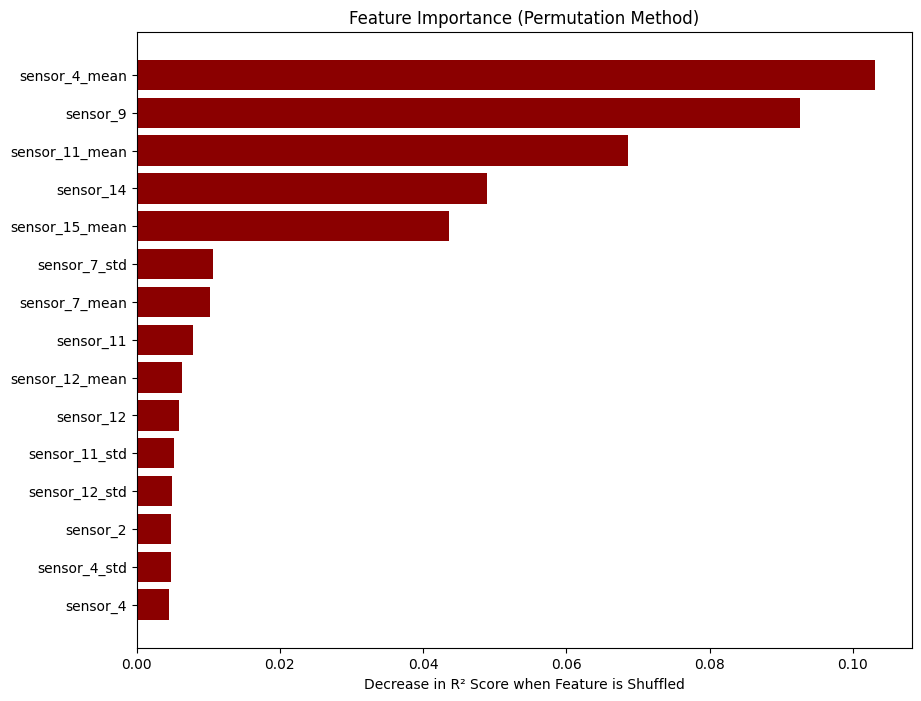

In [228]:
# Let's check how much each feature influences our model.
from sklearn.inspection import permutation_importance

# Calculate Permutation Importance
result = permutation_importance(
    best_pipeline, X, y, n_repeats=5, random_state=8, n_jobs=-1
)

# Extract the importances
feature_names = X.columns
importances = result.importances_mean

# Create a DataFrame to help plot
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'].head(15), feature_importance_df['Importance'].head(15), color='darkred')
plt.gca().invert_yaxis()
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Decrease in R² Score when Feature is Shuffled')
plt.show()

## 12. Conclusions

This project successfully developed a robust predictive maintenance pipeline for aircraft turbofan engines using the NASA CMAPSS dataset. The final model achieved a high degree of accuracy and operational reliability.

### Summary of Methodology

The final architecture utilized a HistGradientBoostingRegressor integrated into a Scikit-Learn pipeline. The core of the model's performance relied on three engineering decisions:

>Clipping RUL: Implementing a 115 clipping threshold accounted for the non-linear nature of engine degradation, preventing the model from attempting to learn from noisy signals during the healthy operation phase.

>Temporal Feature Engineering: By incorporating 10-cycle rolling means and standard deviations for high-correlation sensors, the model was transformed from a reactive observer to a proactive system.

>Automated Optimization: The use of RandomizedSearchCV allowed for the efficient discovery of optimal hyperparameters, ensuring the model balanced complexity with generalization.

### Performance Highlights

The model's final evaluation on unseen test engines yielded the following metrics:

>Mean Absolute Error (MAE): ~13.80 cycles

>Root Mean Squared Error (RMSE): ~18.80 cycles

>R2 Score: ~0.80

### Engineering Insights

Analysis through Permutation Importance revealed that engineered features—specifically the rolling means of sensors related to high-pressure compressor temperatures and bypass ratios—were the primary drivers of the model's predictive power. This confirms that in high-stakes mechanical systems, the trend of degradation is a more reliable signal than the raw sensor value at any single moment.

### Operational and Business Impact

From an aviation management perspective, this model provides several key benefits:

>Reduced Unscheduled Downtime: By identifying failure patterns 13-14 cycles in advance, airlines can move from reactive "break-fix" cycles to "just-in-time" maintenance.

>Safety Margin Optimization: The RMSE of 18.8 cycles provides a clear statistical safety buffer for maintenance planning, allowing engineers to set conservative thresholds for inspections.

### Future Work

While the current model is effective for the FD001 operating conditions, future iterations could explore:

>FD002-FD004: Expanding the pipeline to handle more complex datasets (FD002-FD004) that involve multiple flight conditions and altitude variations.

>Advanced AI/ML Models: Using advanced models to further improve model prediction, accuracy and RMSE.